
## Prototype: NSFW Image Detector (Male Genital Shaped Items)
### Machine Learning and Neural Networks (Template 2: Gather your own dataset)

Image Classification using CNN Keras | Full implementation
<br>
Source: https://www.youtube.com/watch?v=J1jhfAw5Uvo

Prototype main objective: able to classify positive or negative images to accuracy above 50%

- Binary classification task

In [1]:
#import libraries
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
#import tensorflow_hub as hub
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras import regularizers

In [2]:
# import datat from CSV, labeled as one or zero
one_data = np.load('../192-144/1_output.npy')
one_label = np.load('../192-144/1_labels.npy')
zero_data = np.load('../192-144/0_output.npy')
zero_label = np.load('../192-144/0_labels.npy')
#check dtype
type(one_data[0][0])

numpy.uint8

In [3]:
print(one_data.shape)

(112693, 82944)


In [4]:
#reshape into 192 x 192 pixels
one_data = one_data.reshape(len(one_data), 192, 144, 3)
zero_data = zero_data.reshape(len(zero_data), 192, 144, 3)

In [5]:
one_data = tf.data.Dataset.from_tensor_slices((one_data, one_label))
zero_data = tf.data.Dataset.from_tensor_slices((zero_data, zero_label))

In [6]:
one_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(192, 144, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
def scale(image, label):
    return (tf.cast(image, tf.float32) / 255.0, label)

In [8]:
one_data = one_data.map(scale, num_parallel_calls = tf.data.AUTOTUNE)
zero_data = zero_data.map(scale, num_parallel_calls = tf.data.AUTOTUNE)

for image, label in one_data:
    pass

for image, label in zero_data:
    pass

In [9]:
print(len(one_data))
print(len(zero_data))

112693
112707


In [10]:
one_data = one_data.shuffle(buffer_size=len(one_data), reshuffle_each_iteration=True)
zero_data = zero_data.shuffle(buffer_size=len(zero_data), reshuffle_each_iteration=True)

#@tf.function
def loop():
    for epoch in tf.range(2):
        for d in one_data:
            tf.print(d)


loop()

In [11]:
# custom test, train val split

one_DATASET_SIZE = (len(one_data))
zero_DATASET_SIZE = (len(zero_data))

one_train_size = int(0.5 * one_DATASET_SIZE)
one_val_size = int(0.25 * one_DATASET_SIZE)
one_test_size = int(0.25 * one_DATASET_SIZE)

zero_train_size = int(0.5 * zero_DATASET_SIZE)
zero_val_size = int(0.25 * zero_DATASET_SIZE)
zero_test_size = int(0.25 * zero_DATASET_SIZE)

one_train_dataset = one_data.take(one_train_size)
one_test_dataset = one_data.skip(one_train_size)
one_val_dataset = one_test_dataset.skip(one_val_size)
one_test_dataset = one_test_dataset.take(one_test_size)

zero_train_dataset = zero_data.take(zero_train_size)
zero_test_dataset = zero_data.skip(zero_train_size)
zero_val_dataset = zero_test_dataset.skip(zero_val_size)
zero_test_dataset = zero_test_dataset.take(zero_test_size)

In [12]:
# check len of all 3 sets
print("Train set:", len(one_train_dataset))
print("Test set:", len(one_test_dataset))
print("Valadation set:", len(one_val_dataset))

Train set: 56346
Test set: 28173
Valadation set: 28174


In [13]:
## merge zero and one datasets and shuffle 

train_dataset = one_train_dataset.concatenate(zero_train_dataset)
test_dataset = one_test_dataset.concatenate(zero_test_dataset)
val_dataset = one_val_dataset.concatenate(zero_val_dataset)

#shuffle
train_dataset = train_dataset.shuffle(buffer_size=len(train_dataset))
test_dataset = test_dataset.shuffle(buffer_size=len(test_dataset))
val_dataset = val_dataset.shuffle(buffer_size=len(val_dataset))

# check len of all 3 sets
print("Train set:", len(train_dataset))
print("Test set:", len(test_dataset))
print("Valadation set:", len(val_dataset))


Train set: 112699
Test set: 56349
Valadation set: 56352


In [14]:
val_dataset

<_ShuffleDataset element_spec=(TensorSpec(shape=(192, 144, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
# batch the sets, default for tf.dataset is 32
batched_train_dataset = train_dataset.batch(96)
batched_test_dataset = test_dataset.batch(96)
batched_val_dataset = val_dataset.batch(96)

In [16]:
batched_val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 192, 144, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [17]:
# check for un used var clogging memory / memory leak

from __future__ import print_function  # for Python2
import sys

local_vars = list(locals().items())
for var, obj in local_vars:
    # print var over 1gb for removal
    if (sys.getsizeof(obj) / 10000000) >= 1:
        print(var, sys.getsizeof(obj) / 10000000 )

# building model

In [18]:
# define function that can run sequential models back to back

def build_model(dropout_units):
    model = Sequential()
    model.add(Conv2D(32, (3,3), strides=2, activation = 'relu', input_shape = (192, 144, 3)))
    model.add(MaxPooling2D((2,2))) 
    model.add(Dropout(dropout_units))
    model.add(Conv2D(96, (3,3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D((2,2), strides=2))
    model.add(Dropout(dropout_units))
    
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(dropout_units))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(dropout_units))
    model.add(Dense(1, activation = 'sigmoid'))
    #optimizers 
    model.compile(loss = 'binary_crossentropy', optimizer = "Adam", metrics = ['accuracy'])
    return model    
#model.summary()

# custom progress bar


In [19]:
histories = {}

#can input number of hidden units for each layer. Here we will test an increasing large number of hidden units
for i in [0, 0.05, 0.1, 0.2, 0.3, 0.4]:
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    model = build_model(i)
    model_name = str(64) + '-' + str(64) + '-'+ str(64) + '-'+ str(1) + '-' + str(i) 
    print('Training', model_name)
    history = model.fit(batched_train_dataset,
                        epochs= 10,
                        validation_data=batched_val_dataset,
                        verbose = 1,
                        callbacks=[callback]
                       )
    histories[model_name] = history
    results = model.evaluate(batched_test_dataset)
    model.summary()
    model.reset_states() 

#model.reset_states() 





Training 64-64-64-1-0
Epoch 1/10


1174/1174 [==============================] - 434s 294ms/step - loss: 0.2922 - accuracy: 0.8775 - val_loss: 0.2420 - val_accuracy: 0.9066
Epoch 2/10
1174/1174 [==============================] - 447s 226ms/step - loss: 0.2271 - accuracy: 0.9087 - val_loss: 0.1918 - val_accuracy: 0.9249
Epoch 3/10
1174/1174 [==============================] - 344s 205ms/step - loss: 0.1936 - accuracy: 0.9233 - val_loss: 0.1693 - val_accuracy: 0.9336
Epoch 4/10
1174/1174 [==============================] - 317s 196ms/step - loss: 0.1716 - accuracy: 0.9336 - val_loss: 0.1649 - val_accuracy: 0.9369
Epoch 5/10
1174/1174 [==============================] - 297s 183ms/step - loss: 0.1582 - accuracy: 0.9382 - val_loss: 0.1386 - val_accuracy: 0.9469
Epoch 6/10
1174/1174 [==============================] - 273s 168ms/step - loss: 0.1480 - accuracy: 0.9426 - val_loss: 0.1316 - val_accuracy: 0.9489
Epoch 7/10
1174/1174 [==============================] - 246s 158ms/step - loss: 0.140

In [20]:
histories[model_name] = history

In [21]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
# plot training and validation loss helper functions for future use
acc = history_dict['accuracy']
#define training accuracy 
def plot_acc_comparison(acc_a, label_a, acc_b, label_b,acc_c, label_c, acc_d, label_d, acc_e, label_e, acc_f, label_f, y_label):
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc_a, label=label_a)
    plt.plot(epochs, acc_b, label=label_b)    
    plt.plot(epochs, acc_c, label=label_c) 
    plt.plot(epochs, acc_d, label=label_d) 
    plt.plot(epochs, acc_e, label=label_e) 
    plt.plot(epochs, acc_f, label=label_f) 
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

#define validation accuracy 
def plot_val_acc_comparison(val_acc_a, label_a,val_acc_b, label_b, val_acc_c, label_c, val_acc_d, label_d, val_acc_e, label_e, val_acc_f, label_f, y_label):
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, val_acc_a, label=label_a)
    plt.plot(epochs, val_acc_b, label=label_b)    
    plt.plot(epochs, val_acc_c, label=label_c) 
    plt.plot(epochs, val_acc_d, label=label_d) 
    plt.plot(epochs, val_acc_e, label=label_e) 
    plt.plot(epochs, val_acc_f, label=label_f) 
    plt.title('Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    
#define validation loss     
def plot_loss_comparison(loss_a, label_a, loss_b, label_b, loss_c, label_c, loss_d, label_d, loss_e, label_e, loss_f, label_f, y_label):
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss_a, label=label_a)
    plt.plot(epochs, loss_b, label=label_b)    
    plt.plot(epochs, loss_c, label=label_c)
    plt.plot(epochs, loss_d, label=label_d)
    plt.plot(epochs, loss_e, label=label_e)
    plt.plot(epochs, loss_f, label=label_f)
    plt.title('Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()
    
#define training loss
def plot_training_loss_comparison(tloss_a, label_a, tloss_b, label_b, tloss_c, label_c, tloss_d, label_d, tloss_e, label_e, tloss_f, label_f, y_label):
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, tloss_a, label=label_a)
    plt.plot(epochs, tloss_b, label=label_b)    
    plt.plot(epochs, tloss_c, label=label_c) 
    plt.plot(epochs, tloss_d, label=label_d) 
    plt.plot(epochs, tloss_e, label=label_e) 
    plt.plot(epochs, tloss_f, label=label_f) 
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.show()    

In [33]:
#plot for network a
def plot_net_a(acc , label_a, val_acc , label_b, tloss, label_c, loss, label_d, y_label):    
    epochs = range(1, len(acc) + 1)         
    plt.plot(epochs, acc, 'b', label=label_a)
    plt.plot(epochs, val_acc, 'g', label=label_b)    
    plt.plot(epochs, tloss, 'y', label=label_c) 
    plt.plot(epochs, loss, 'm', label=label_d) 
    plt.title('Network A: ' + net_a)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()
#plot for network b 
def plot_net_b(acc , label_a, val_acc , label_b, tloss, label_c, loss, label_d, y_label):    
    epochs = range(1, len(acc) + 1)         
    plt.plot(epochs, acc, 'b', label=label_a)
    plt.plot(epochs, val_acc, 'g', label=label_b)    
    plt.plot(epochs, tloss, 'y', label=label_c) 
    plt.plot(epochs, loss, 'm', label=label_d) 
    plt.title('Network B: ' + net_b)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()    
#plot for network c 
def plot_net_c(acc , label_a, val_acc , label_b, tloss, label_c, loss, label_d, y_label):    
    epochs = range(1, len(acc) + 1)         
    plt.plot(epochs, acc, 'b', label=label_a)
    plt.plot(epochs, val_acc, 'g', label=label_b)    
    plt.plot(epochs, tloss, 'y', label=label_c) 
    plt.plot(epochs, loss, 'm', label=label_d) 
    plt.title('Network C: ' + net_c)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()
#plot for network d 
def plot_net_d(acc , label_a, val_acc , label_b, tloss, label_c, loss, label_d, y_label):    
    epochs = range(1, len(acc) + 1)         
    plt.plot(epochs, acc, 'b', label=label_a)
    plt.plot(epochs, val_acc, 'g', label=label_b)    
    plt.plot(epochs, tloss, 'y', label=label_c) 
    plt.plot(epochs, loss, 'm', label=label_d) 
    plt.title('Network D: ' + net_d)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()
#plot for network e
def plot_net_e(acc , label_a, val_acc , label_b, tloss, label_c, loss, label_d, y_label):    
    epochs = range(1, len(acc) + 1)         
    plt.plot(epochs, acc, 'b', label=label_a)
    plt.plot(epochs, val_acc, 'g', label=label_b)    
    plt.plot(epochs, tloss, 'y', label=label_c) 
    plt.plot(epochs, loss, 'm', label=label_d) 
    plt.title('Network E: ' + net_e)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()  
    
def plot_net_f(acc , label_a, val_acc , label_b, tloss, label_c, loss, label_d, y_label):    
    epochs = range(1, len(acc) + 1)         
    plt.plot(epochs, acc, 'b', label=label_a)
    plt.plot(epochs, val_acc, 'g', label=label_b)    
    plt.plot(epochs, tloss, 'y', label=label_c) 
    plt.plot(epochs, loss, 'm', label=label_d) 
    plt.title('Network E: ' + net_f)
    plt.xlabel('Epochs')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()  

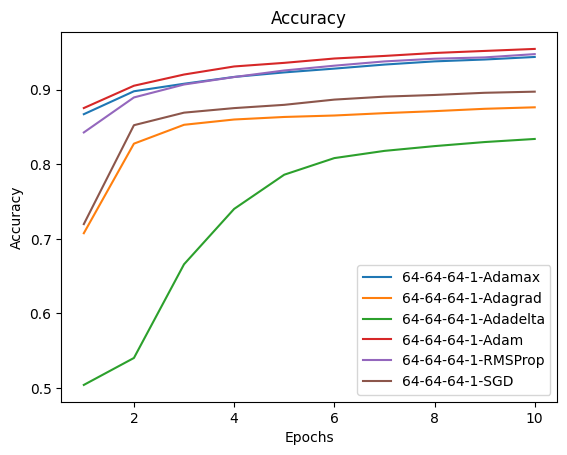

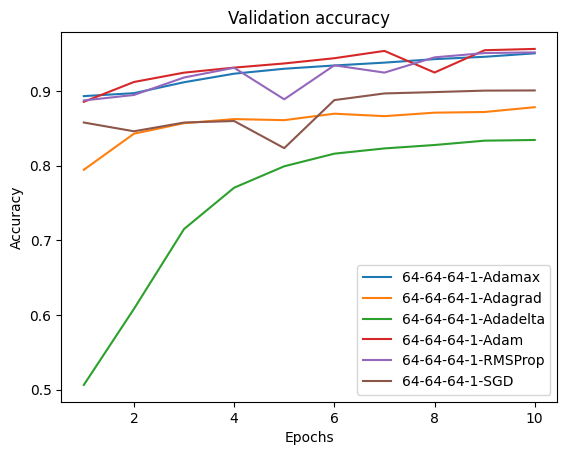

In [28]:
#declare networks according to "histories[model_name]"

net_a, net_b, net_c, net_d, net_e, net_f = '64-64-64-1-Adamax', '64-64-64-1-Adagrad', '64-64-64-1-Adadelta', '64-64-64-1-Adam', '64-64-64-1-RMSProp', '64-64-64-1-SGD'
#plotting accuracy
plot_acc_comparison(acc_a=histories[net_a].history['accuracy'], label_a=net_a,
                     acc_b=histories[net_b].history['accuracy'], label_b=net_b,
                     acc_c=histories[net_c].history['accuracy'], label_c=net_c,
                    acc_d=histories[net_d].history['accuracy'], label_d=net_d,
                    acc_e=histories[net_e].history['accuracy'], label_e=net_e, 
                    acc_f=histories[net_f].history['accuracy'], label_f=net_f, 
                    y_label='Accuracy')
#plotting validation accuracy
plot_val_acc_comparison(val_acc_a=histories[net_a].history['val_accuracy'], label_a=net_a,
                     val_acc_b=histories[net_b].history['val_accuracy'], label_b=net_b,
                     val_acc_c=histories[net_c].history['val_accuracy'], label_c=net_c,
                        val_acc_d=histories[net_d].history['val_accuracy'], label_d=net_d,
                        val_acc_e=histories[net_e].history['val_accuracy'], label_e=net_e, 
                        val_acc_f=histories[net_f].history['val_accuracy'], label_f=net_f, 
                        y_label='Accuracy')

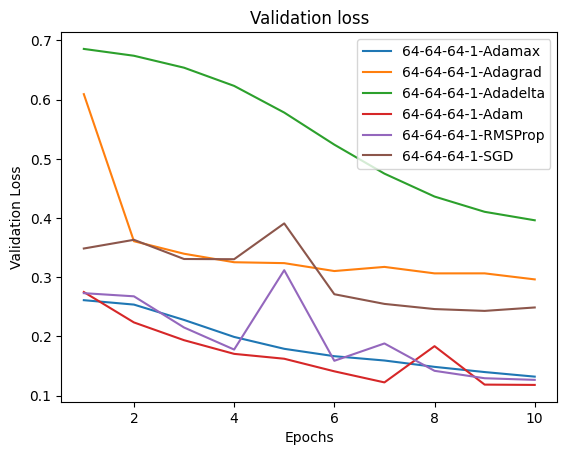

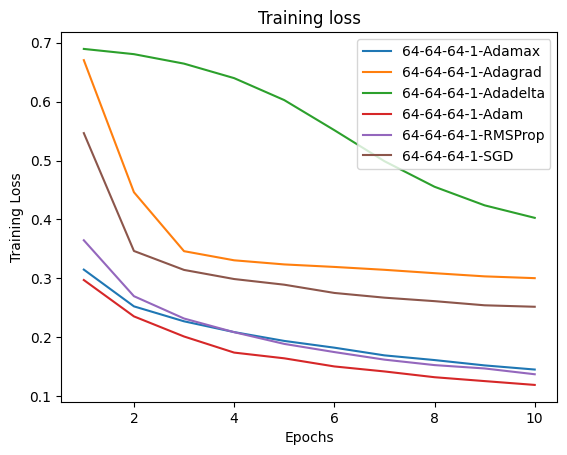

In [31]:
# plotting loss and validation loss
plot_loss_comparison(loss_a=histories[net_a].history['val_loss'], label_a=net_a,
                     loss_b=histories[net_b].history['val_loss'], label_b=net_b,
                     loss_c=histories[net_c].history['val_loss'], label_c=net_c,
                     loss_d=histories[net_d].history['val_loss'], label_d=net_d,
                     loss_e=histories[net_e].history['val_loss'], label_e=net_e,
                     loss_f=histories[net_f].history['val_loss'], label_f=net_f,
                        y_label='Validation Loss')

plot_training_loss_comparison(tloss_a=histories[net_a].history['loss'], label_a=net_a,
                     tloss_b=histories[net_b].history['loss'], label_b=net_b,
                     tloss_c=histories[net_c].history['loss'], label_c=net_c,
                    tloss_d=histories[net_d].history['loss'], label_d=net_d,
                    tloss_e=histories[net_e].history['loss'], label_e=net_e,
                    tloss_f=histories[net_f].history['loss'], label_f=net_f,
                        y_label='Training Loss')

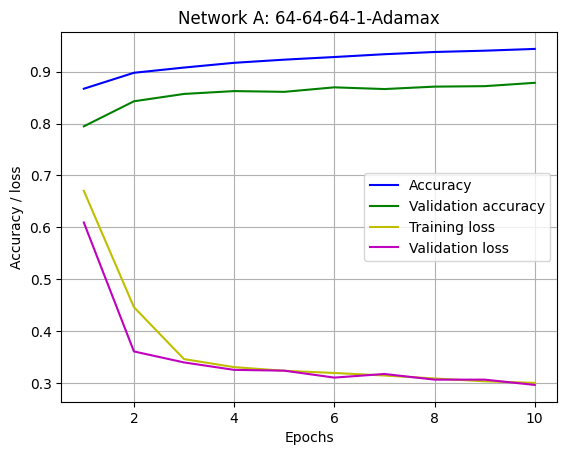

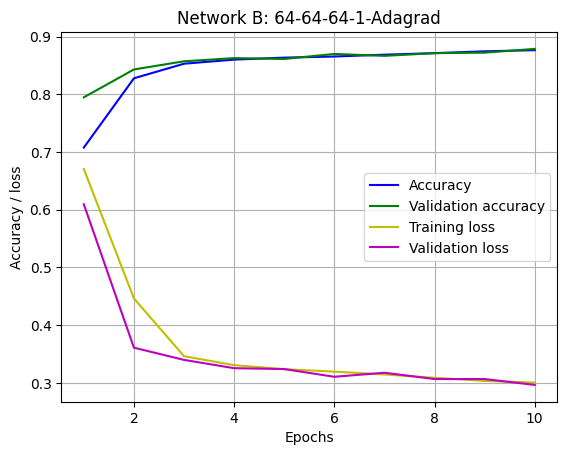

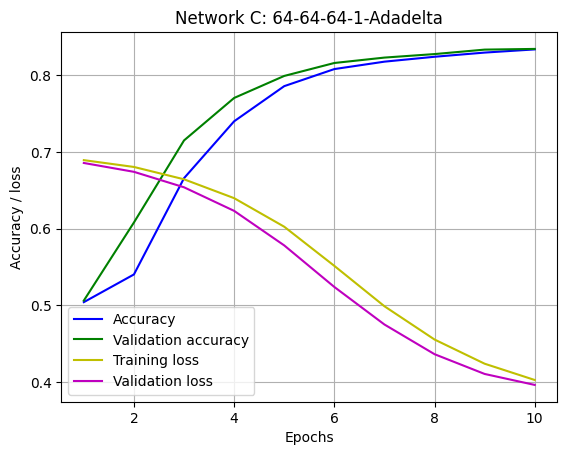

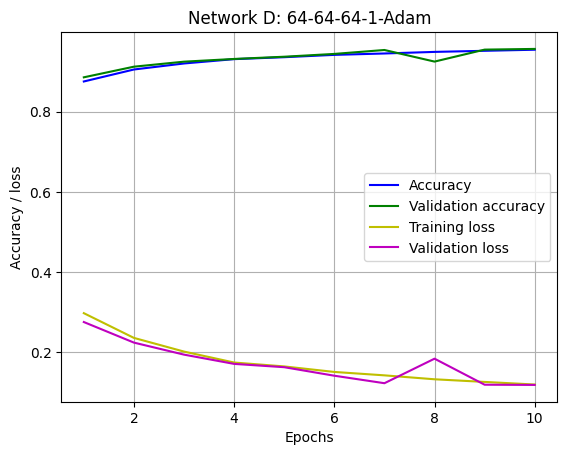

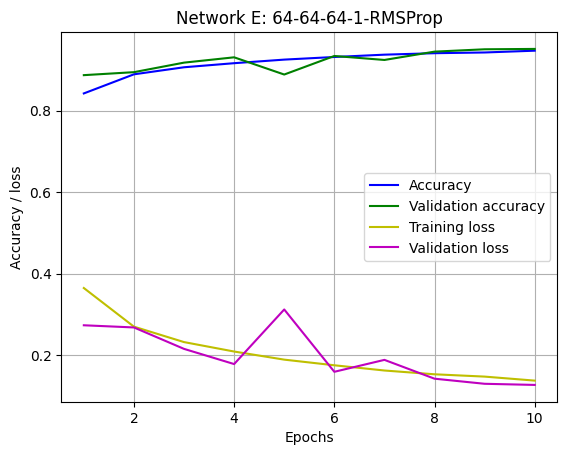

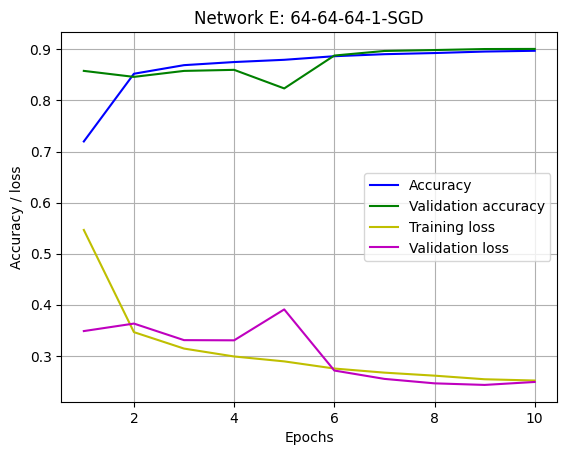

In [34]:
# selecting network a, b, c, d, e
plot_net_a(acc=histories[net_a].history['accuracy'], label_a="Accuracy",
           val_acc=histories[net_b].history['val_accuracy'], label_b="Validation accuracy",
            tloss=histories[net_b].history['loss'], label_c="Training loss",
            loss=histories[net_b].history['val_loss'], label_d="Validation loss", y_label='Accuracy / loss')

plot_net_b(acc=histories[net_b].history['accuracy'], label_a="Accuracy",
           val_acc=histories[net_b].history['val_accuracy'], label_b="Validation accuracy",
            tloss=histories[net_b].history['loss'], label_c="Training loss",
            loss=histories[net_b].history['val_loss'], label_d="Validation loss", y_label='Accuracy / loss')

plot_net_c(acc=histories[net_c].history['accuracy'], label_a="Accuracy",
            val_acc=histories[net_c].history['val_accuracy'], label_b="Validation accuracy",
            tloss=histories[net_c].history['loss'], label_c="Training loss",
            loss=histories[net_c].history['val_loss'], label_d="Validation loss", y_label='Accuracy / loss')

plot_net_d(acc=histories[net_d].history['accuracy'], label_a="Accuracy",
            val_acc=histories[net_d].history['val_accuracy'], label_b="Validation accuracy",
            tloss=histories[net_d].history['loss'], label_c="Training loss",
            loss=histories[net_d].history['val_loss'], label_d="Validation loss", y_label='Accuracy / loss')

plot_net_e(acc=histories[net_e].history['accuracy'], label_a="Accuracy",
            val_acc=histories[net_e].history['val_accuracy'], label_b="Validation accuracy",
            tloss=histories[net_e].history['loss'], label_c="Training loss",
            loss=histories[net_e].history['val_loss'], label_d="Validation loss", y_label='Accuracy / loss')

plot_net_f(acc=histories[net_f].history['accuracy'], label_a="Accuracy",
            val_acc=histories[net_f].history['val_accuracy'], label_b="Validation accuracy",
            tloss=histories[net_f].history['loss'], label_c="Training loss",
            loss=histories[net_f].history['val_loss'], label_d="Validation loss", y_label='Accuracy / loss')